In [31]:
"""
train_xenium_embeddings.py

Loads 2k-matched Xenium spatial + scRNA datasets,
trains:
  - Supervised VAE on reference dataset (B)
  - GNN encoder on spatial dataset (A)
  - MMD alignment loss between the two latent spaces

Outputs:
  - z_ref.npy   (reference latent embeddings)
  - z_spatial.npy (spatial latent embeddings)
  - model weights (vae.pt, gnn.pt)
"""

import numpy as np
import scanpy as sc
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neighbors import kneighbors_graph
from torch.utils.data import DataLoader, TensorDataset

In [32]:
# ----------------------------------------------------
# 1. Model components
# ----------------------------------------------------

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=256):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.logvar = nn.Linear(hidden_dim // 2, latent_dim)

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, input_dim)
        )

    def encode(self, x):
        h = self.enc(x)
        return self.mu(h), self.logvar(h)

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar, z


class GNNEncoder(nn.Module):
    """Simple GCN-like encoder: A_norm @ X @ W1 -> ReLU -> A_norm @ (hidden) @ W2"""

    def __init__(self, input_dim, latent_dim, hidden_dim=256):
        super().__init__()
        self.lin1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.lin2 = nn.Linear(hidden_dim, latent_dim, bias=True)

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, input_dim)
        )

    def forward(self, X, A_norm):
        H = torch.relu(A_norm @ self.lin1(X))
        Z = A_norm @ self.lin2(H)
        recon = self.dec(Z)
        return recon, Z


In [33]:
# ----------------------------------------------------
# 2. MMD loss
# ----------------------------------------------------

def pairwise_distances(x, y):
    x_norm = (x ** 2).sum(dim=1).view(-1, 1)
    y_norm = (y ** 2).sum(dim=1).view(1, -1)
    dist = x_norm + y_norm - 2 * (x @ y.t())
    return torch.clamp(dist, min=0.)

def gaussian_kernel(x, y, sigma):
    dist = pairwise_distances(x, y)
    return torch.exp(-dist / (2 * sigma * sigma))

def mmd_rbf(x, y, sigmas=(1, 2, 4, 8)):
    Kxx = 0; Kyy = 0; Kxy = 0
    for s in sigmas:
        Kxx += gaussian_kernel(x, x, s).mean()
        Kyy += gaussian_kernel(y, y, s).mean()
        Kxy += gaussian_kernel(x, y, s).mean()
    return Kxx + Kyy - 2 * Kxy


In [34]:
# ----------------------------------------------------
# 3. Load data
# ----------------------------------------------------

def load_data():
    A = sc.read_h5ad("SmallData/xenium_spatial_common_genes.h5ad")
    B = sc.read_h5ad("SmallData/xenium_reference_common_genes.h5ad")

    A_X = np.log1p(A.X.toarray()) if hasattr(A.X, "toarray") else np.log1p(A.X)
    B_X = np.log1p(B.X.toarray()) if hasattr(B.X, "toarray") else np.log1p(B.X)

    # spatial coordinates
    spatial_coords = A.obsm["spatial"]

    return A_X.astype("float32"), B_X.astype("float32"), spatial_coords

In [35]:
# ----------------------------------------------------
# 4. Build spatial adjacency
# ----------------------------------------------------

def build_adj(coords, k=10):
    A = kneighbors_graph(coords, k, mode="connectivity", include_self=True).toarray()
    A = (A + A.T) / 2
    A += np.eye(A.shape[0])
    deg = A.sum(1)
    D_inv = np.diag(1.0 / np.sqrt(deg + 1e-8))
    A_norm = D_inv @ A @ D_inv
    return torch.tensor(A_norm, dtype=torch.float32)


In [36]:
# ----------------------------------------------------
# 5. Training loop
# ----------------------------------------------------

def train_model(A_X, B_X, coords, latent_dim=10, epochs=80):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    A_tensor = torch.tensor(A_X, device=device)
    B_tensor = torch.tensor(B_X, device=device)

    N_B, G = B_X.shape
    A_adj = build_adj(coords).to(device)

    # Models
    vae = VAE(input_dim=G, latent_dim=latent_dim).to(device)
    gnn = GNNEncoder(input_dim=G, latent_dim=latent_dim).to(device)

    # Loader for reference
    B_loader = DataLoader(
        TensorDataset(B_tensor),
        batch_size=128,
        shuffle=True
    )

    opt = optim.Adam(list(vae.parameters()) + list(gnn.parameters()), lr=1e-3)
    mse = nn.MSELoss()

    for ep in range(1, epochs + 1):
        vae.train()
        gnn.train()

        for (b_batch,) in B_loader:
            # Forward VAE
            recon_b, mu_b, logvar_b, z_b = vae(b_batch)

            recon_loss_b = mse(recon_b, b_batch)
            kl = -0.5 * torch.mean(1 + logvar_b - mu_b**2 - torch.exp(logvar_b))
            loss_vae = recon_loss_b + kl

            # Forward GNN on full A
            recon_a, z_a = gnn(A_tensor, A_adj)
            loss_gnn = mse(recon_a, A_tensor)

            # Comparative MMD
            # sample same size batch from z_a
            idx = np.random.choice(len(z_a), size=min(len(b_batch), len(z_a)), replace=False)
            z_a_sub = z_a[idx]

            loss_mmd = mmd_rbf(z_b, z_a_sub)

            loss = loss_vae + loss_gnn + loss_mmd

            opt.zero_grad()
            loss.backward()
            opt.step()

        print(f"Epoch {ep:03d} | VAE={loss_vae.item():.4f} | GNN={loss_gnn.item():.4f} | MMD={loss_mmd.item():.4f}")

    # Save final embeddings
    vae.eval()
    gnn.eval()

    with torch.no_grad():
        _, _, _, z_ref = vae(B_tensor)
        _, z_spatial = gnn(A_tensor, A_adj)

    np.save("Results/z_ref.npy", z_ref.cpu().numpy())
    np.save("Results/z_spatial.npy", z_spatial.cpu().numpy())

    torch.save(vae.state_dict(), "Results/vae.pt")
    torch.save(gnn.state_dict(), "Results/gnn.pt")

    print("Saved: Results/z_ref.npy, Results/z_spatial.npy, Results/vae.pt, Results/gnn.pt")

In [37]:
A_X, B_X, coords = load_data()
train_model(A_X, B_X, coords)

Epoch 001 | VAE=0.2142 | GNN=0.2459 | MMD=0.4052
Epoch 002 | VAE=0.0989 | GNN=0.1951 | MMD=0.4223
Epoch 003 | VAE=0.0981 | GNN=0.1809 | MMD=0.3419
Epoch 004 | VAE=0.0969 | GNN=0.1731 | MMD=0.2282
Epoch 005 | VAE=0.0919 | GNN=0.1700 | MMD=0.2411
Epoch 006 | VAE=0.0891 | GNN=0.1675 | MMD=0.2042
Epoch 007 | VAE=0.0871 | GNN=0.1679 | MMD=0.2298
Epoch 008 | VAE=0.0841 | GNN=0.1657 | MMD=0.2042
Epoch 009 | VAE=0.0848 | GNN=0.1648 | MMD=0.1870
Epoch 010 | VAE=0.0866 | GNN=0.1645 | MMD=0.1834
Epoch 011 | VAE=0.0836 | GNN=0.1642 | MMD=0.1834
Epoch 012 | VAE=0.0835 | GNN=0.1633 | MMD=0.1738
Epoch 013 | VAE=0.0876 | GNN=0.1629 | MMD=0.1455
Epoch 014 | VAE=0.0839 | GNN=0.1626 | MMD=0.1678
Epoch 015 | VAE=0.0856 | GNN=0.1617 | MMD=0.2055
Epoch 016 | VAE=0.0826 | GNN=0.1616 | MMD=0.1523
Epoch 017 | VAE=0.0813 | GNN=0.1615 | MMD=0.1727
Epoch 018 | VAE=0.0857 | GNN=0.1618 | MMD=0.1436
Epoch 019 | VAE=0.0812 | GNN=0.1614 | MMD=0.1973
Epoch 020 | VAE=0.0824 | GNN=0.1608 | MMD=0.1918
Epoch 021 | VAE=0.08

In [38]:
# ----------------------------------------------------
# 7. Visualization of embeddings (UMAP + PCA)
# ----------------------------------------------------
def visualize_embeddings(z_ref, z_spatial):
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    import umap

    # ---------------------------
    # PCA
    # ---------------------------
    pca = PCA(n_components=2)
    Z = np.vstack([z_ref, z_spatial])
    Z_pca = pca.fit_transform(Z)

    n_ref = len(z_ref)
    n_spatial = len(z_spatial)

    plt.figure(figsize=(7, 6))
    plt.scatter(Z_pca[:n_ref, 0], Z_pca[:n_ref, 1], 
                s=5, alpha=0.5, label="Reference (VAE)", color="royalblue")
    plt.scatter(Z_pca[n_ref:, 0], Z_pca[n_ref:, 1], 
                s=5, alpha=0.5, label="Spatial (GNN)", color="darkorange")
    plt.title("PCA of Latent Embeddings (Ref + Spatial)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("Plots/embeddings_pca.png", dpi=180)
    plt.show()

    # ---------------------------
    # UMAP (most useful!)
    # ---------------------------
    reducer = umap.UMAP(n_components=2, random_state=42)
    Z_umap = reducer.fit_transform(Z)

    plt.figure(figsize=(7, 6))
    plt.scatter(Z_umap[:n_ref, 0], Z_umap[:n_ref, 1], 
                s=5, alpha=0.5, label="Reference (VAE)", color="royalblue")
    plt.scatter(Z_umap[n_ref:, 0], Z_umap[n_ref:, 1],
                s=5, alpha=0.5, label="Spatial (GNN)", color="darkorange")
    plt.title("UMAP of Latent Embeddings (Ref + Spatial)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("Plots/embeddings_umap.png", dpi=180)
    plt.show()


Visualizing embeddings...


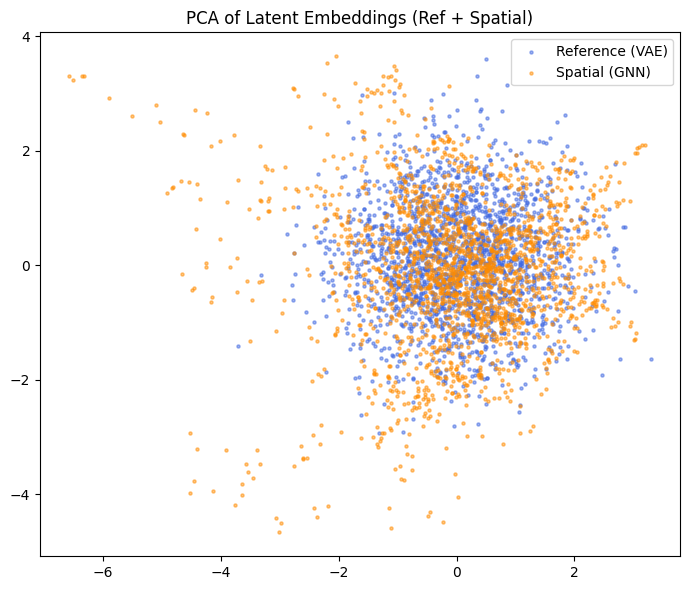

/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


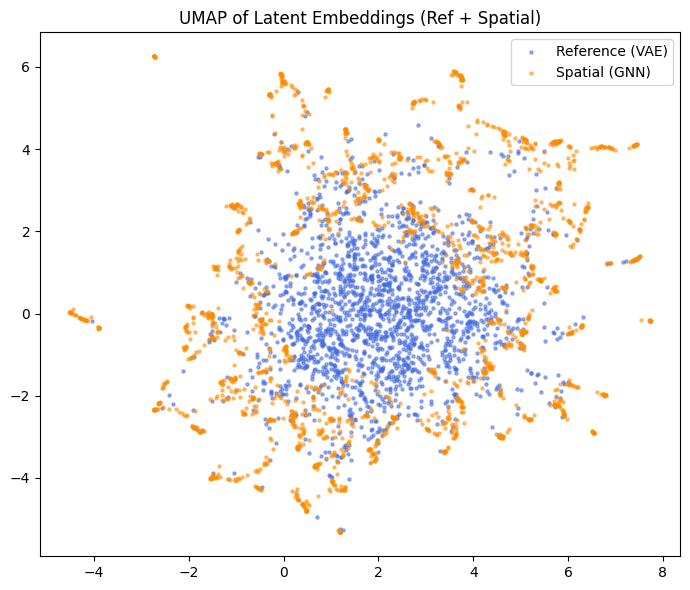

In [39]:
# Load stored embeddings
z_ref = np.load("Results/z_ref.npy")
z_spatial = np.load("Results/z_spatial.npy")

print("\nVisualizing embeddings...")
visualize_embeddings(z_ref, z_spatial)